あるストリーミングサービスの解約率を調べるという状況を想定する  
まずはデータ生成を行う  

ここで解約率を推定するために利用できるデータは以下のものとする。

| 項目 | 説明 | 分布 |
| --- | --- | --- |
| DaysSinceLastActivity | 最終ログインからの日数 | 指数分布: 平均3日 |
| HasActivePromotionalOffer | 復帰を促したか | 二項分布: 0 or 1 |
| AverageSessionDuration | 平均セッション時間 | ガンマ分布: (2,15) 平均30分 |

In [30]:
using Random

Random.seed!(1234)
n_samples = 1000

1000

10-element Vector{Float64}:
  7.979611744641572
 21.94314974976224
 23.057601766391116
  0.6436436167365401
 19.705345663177877
 29.72295859437289
 89.38767091215328
  6.277319776507974
 20.114260785796994
 33.330453133353245

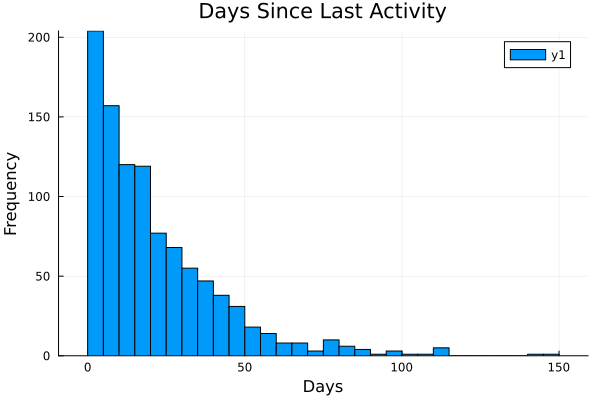

In [31]:
using Distributions
import Plots as P

DaysSinceLastActivity = rand(Exponential(20), n_samples)
display(first(DaysSinceLastActivity, 10))

histogram(
    DaysSinceLastActivity,
    bins=30,
    title="Days Since Last Activity",
    xlabel="Days",
    ylabel="Frequency"
)

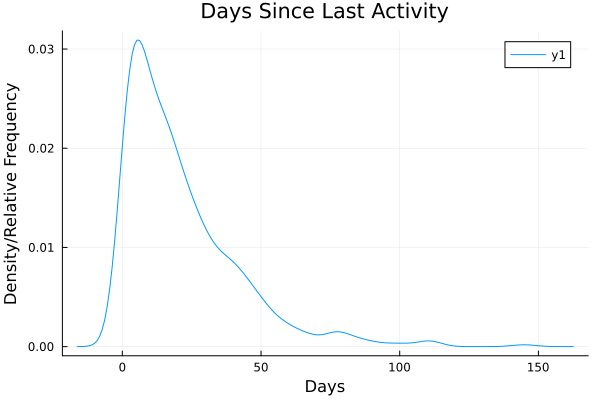

In [32]:
# Density plot
import StatsPlots as SP

SP.histogram(
    DaysSinceLastActivity,
    bins=30,
    alpha=0.5,
    label="Histogram",
    normalize=true
)
plot!(density(DaysSinceLastActivity), label="Density Estimate")
title!("Days Since Last Activity")
xlabel!("Days")
ylabel!("Density/Relative Frequency")